### Урок 7. Классификация с использованием kNN. Кластеризация K-means

1. К алгоритму kNN, реализованному на уроке, реализуйте добавление весов соседей по любому из показанных на уроке принципов.
2. Напишите функцию по подсчёту метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и постройте график её зависимости от k (взять от 1 до 10) для выборки данных из этого урока.

**Задание 1**

К алгоритму kNN, реализованному на уроке, реализуйте добавление весов соседей по любому из показанных на уроке принципов.

Запишем алгоритм, реализованный на уроке.

In [2]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import ListedColormap

In [3]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмём только первые два признака (всего в датасете их 4)
X = X[:, :2]

In [4]:
# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

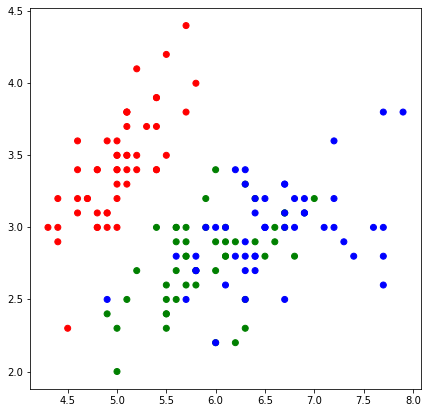

In [5]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

In [6]:
# Используем евклидову метрику. Реализуем функцию для её подсчёта.

def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

Реализуем алгоритм поиска k ближайших соседей.

In [7]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчёт расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаём словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k-элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

Напишем функцию для вычисления точности:

In [8]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Проверим работу алгоритма при различных k:

In [9]:
k = 1

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 1: 0.667


Построим график распределения классов.

In [10]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчёт пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()Построим график распределения классов.

C:\Users\SV\AppData\Local\Temp/ipykernel_2408/1312077004.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


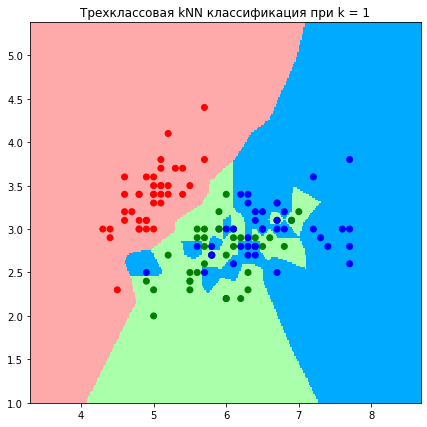

In [11]:
get_graph(X_train, y_train, k)

In [12]:
k = 3

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 3: 0.733


In [13]:
k = 5

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5: 0.867


In [14]:
k = 10

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 10: 0.833


Теперь будем выполнять задание. 

От номера соседа $i$ вес установим следующий:

- $w(i) = q^{i}$,   $q \in (0,1)$;

Изменим функцию knn

In [47]:
def knn_weighted(x_train, y_train, x_test, k, weight=False, q=None):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчёт расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаём словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k-элементов подсчитаем частоту появления разных классов
        for idx, d in enumerate(sorted(test_distances)[0:k]):
            if weight:
                if not q:
                    q = 0.5
                classes[d[1]] += q ** idx
            else:    
                classes[d[1]] += 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [80]:
ks = [1, 3, 5, 10, 15, 20, 100]
acc_list_without_weight = []
# работа алгоритма без наших модификаций
for k in ks:
    y_pred = knn(X_train, y_train, X_test, k)
    acc = accuracy(y_pred, y_test)
    acc_list_without_weight.append(acc)
    print(f'Точность алгоритма при k = {k}: {acc:.3f}')   

Точность алгоритма при k = 1: 0.667
Точность алгоритма при k = 3: 0.733
Точность алгоритма при k = 5: 0.867
Точность алгоритма при k = 10: 0.833
Точность алгоритма при k = 15: 0.833
Точность алгоритма при k = 20: 0.833
Точность алгоритма при k = 100: 0.667


In [81]:
acc_list_without_weight

[0.6666666666666666,
 0.7333333333333333,
 0.8666666666666667,
 0.8333333333333334,
 0.8333333333333334,
 0.8333333333333334,
 0.6666666666666666]

In [82]:
# работа алгоритма с нашими модицикациями без указания веса (по умолчанию 0.5)
for k in ks:
    y_pred =  knn_weighted(X_train, y_train, X_test, k, weight = True)
    print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 1: 0.667
Точность алгоритма при k = 3: 0.667
Точность алгоритма при k = 5: 0.667
Точность алгоритма при k = 10: 0.667
Точность алгоритма при k = 15: 0.667
Точность алгоритма при k = 20: 0.667
Точность алгоритма при k = 100: 0.667


In [86]:
# работа алгоритма с нашими модицикациями с указанием веса
total_list_acc = []
qs = [0.5, 0.6, 0.7, 0.8, 0.9]
for q in qs:
    acc_list = []
    for k in ks:
        y_pred =  knn_weighted(X_train, y_train, X_test, k, weight = True, q=q)
        accur = accuracy(y_pred, y_test)
        acc_list.append(accur)
        print(f'Точность алгоритма при k = {k}, q = {q}: {accur:.3f}')
    total_list_acc.append(acc_list)
    print(' *======* ' * 4)

Точность алгоритма при k = 1, q = 0.5: 0.667
Точность алгоритма при k = 3, q = 0.5: 0.667
Точность алгоритма при k = 5, q = 0.5: 0.667
Точность алгоритма при k = 10, q = 0.5: 0.667
Точность алгоритма при k = 15, q = 0.5: 0.667
Точность алгоритма при k = 20, q = 0.5: 0.667
Точность алгоритма при k = 100, q = 0.5: 0.667
 *======*  *======*  *======*  *======* 
Точность алгоритма при k = 1, q = 0.6: 0.667
Точность алгоритма при k = 3, q = 0.6: 0.667
Точность алгоритма при k = 5, q = 0.6: 0.733
Точность алгоритма при k = 10, q = 0.6: 0.733
Точность алгоритма при k = 15, q = 0.6: 0.733
Точность алгоритма при k = 20, q = 0.6: 0.733
Точность алгоритма при k = 100, q = 0.6: 0.733
 *======*  *======*  *======*  *======* 
Точность алгоритма при k = 1, q = 0.7: 0.667
Точность алгоритма при k = 3, q = 0.7: 0.733
Точность алгоритма при k = 5, q = 0.7: 0.733
Точность алгоритма при k = 10, q = 0.7: 0.767
Точность алгоритма при k = 15, q = 0.7: 0.767
Точность алгоритма при k = 20, q = 0.7: 0.767
Точно

In [87]:
total_list_acc

[[0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666],
 [0.6666666666666666,
  0.6666666666666666,
  0.7333333333333333,
  0.7333333333333333,
  0.7333333333333333,
  0.7333333333333333,
  0.7333333333333333],
 [0.6666666666666666,
  0.7333333333333333,
  0.7333333333333333,
  0.7666666666666667,
  0.7666666666666667,
  0.7666666666666667,
  0.7666666666666667],
 [0.6666666666666666,
  0.7333333333333333,
  0.8,
  0.8333333333333334,
  0.8666666666666667,
  0.8666666666666667,
  0.8666666666666667],
 [0.6666666666666666,
  0.7333333333333333,
  0.8666666666666667,
  0.8666666666666667,
  0.8666666666666667,
  0.8666666666666667,
  0.8666666666666667]]

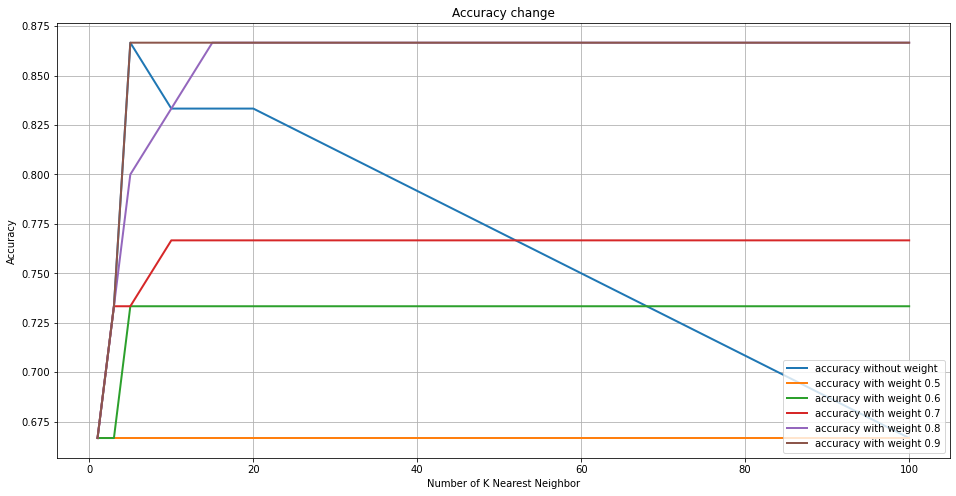

In [92]:
# Визуализируем изменение точности алгоритма
plt.figure(figsize= (16, 8))

plt.plot(ks, acc_list_without_weight, linewidth=2, markersize=7,  label = 'accuracy without weight' )
#plt.plot(trees, test_accuracies, 'c-o', linewidth=2, markersize=7, label = 'test accuracy')
for idx, i in enumerate(total_list_acc):
    plt.plot(ks, i, linewidth=2, markersize=7,  label = f'accuracy with weight {qs[idx]}' )
    
plt.title('Accuracy change')
plt.xlabel('Number of K Nearest Neighbor')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(loc='lower right')

**Выводы**

Мы попробовали проанализировать работу алгоритма KNN без весов для каждого соседа в зависимости от его удаленности от целевой точки, а также работу алгоритма с заданными весами по формуле: 

- $w(i) = q^{i}$,   $q \in (0,1)$;

Изучили алгоритм с весами 0.5, 0.6, 0.7, 0.8, 0.9.

Выводы: 

Без весов алгоритм показывает хороший результат при k=5:

Точность алгоритма при k = 5: 0.867

А далее его точность начинается снижаться. 

При весе 0.5 алгоритм дает всегда одиниковую точность 0.67. Думаю, это связано с тем, что учитывается только 1е несколько соседей, а влияние остальных начинает "зануляться".

Веса 0.6 и 0.7 дают чуть более лучший результат, но суть такая же. Дальше определенного порога влияние соседей очень слабое. 

Наилучший резульат показал вес 0.9. 

Он также показывает лучшую точность при k=5, но далее она не снижается как при работе без весов, а сохраняется вплоть до k=100. 